# Training Landmark Image Classification Model Using Transfer Learning

In [1]:
# Set up some basic parameters for our training.
batch_size = 64
valid_size = 0.2
num_epochs = 20
num_classes = 50
learning_rate = 0.0002
opt = 'adam'
weight_decay = 0.0009

In [8]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.model import get_transfer_learning_model

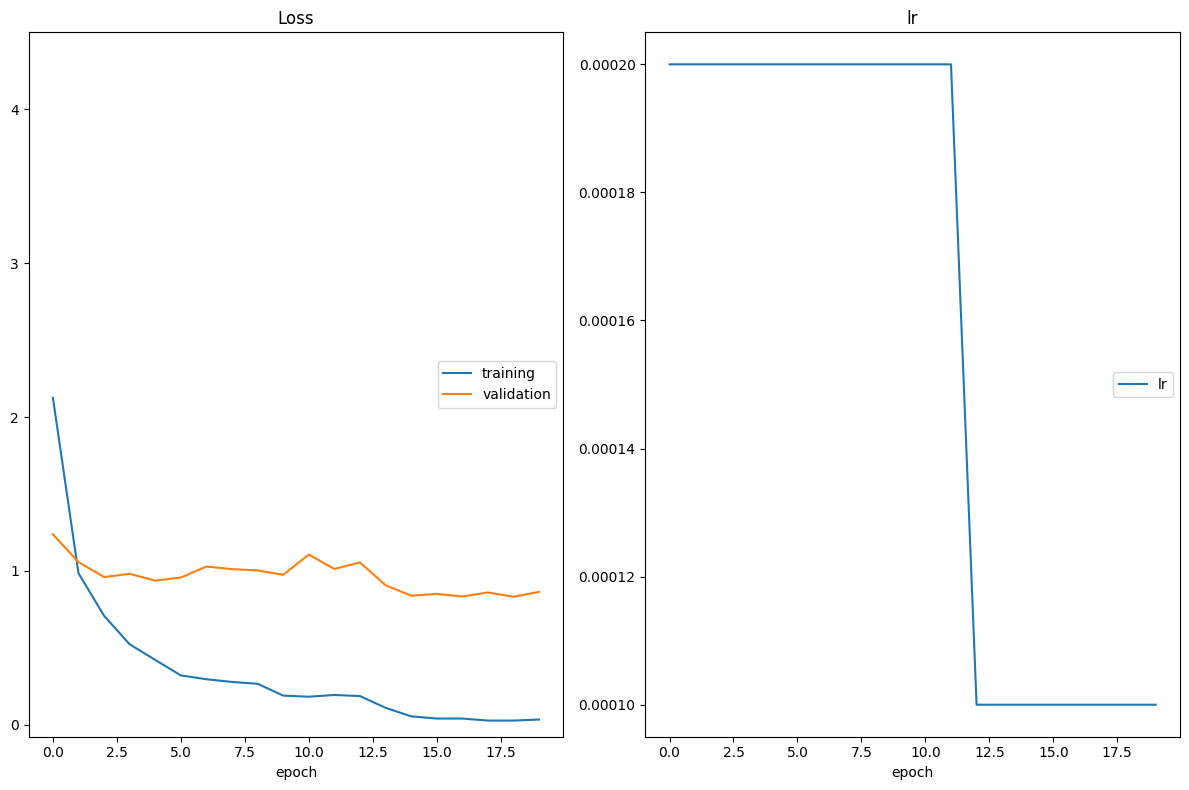

In [8]:
model_transfer = get_transfer_learning_model('resnet50', num_classes)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt"
)

## Testing the final model

In [9]:
import torch
from src.train import one_epoch_test
from src.model import get_transfer_learning_model

model_transfer = get_transfer_learning_model("resnet50", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt', map_location='cpu'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 20/20 [03:12<00:00,  9.61s/it]

Test Loss: 0.687959


Test Accuracy: 84% (1050/1250)


(0.6879585906863213, tensor(84.))

## Prepare our production model

In the event we use this model, we will go ahead and create the version we will use for inference. This will be a class that wraps our model.

In [10]:
from src.production import Predictor
from src.data import get_data_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

model_transfer = model_transfer.cpu()
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = get_data_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

In [11]:
import torch
from src.production import predictor_test

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(model_reloaded)

code/__torch__/torchvision/transforms/functional.py:188: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
code/__torch__/torchvision/transforms/functional.py:188: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass an

Accuracy: 0.828


code/__torch__/torchvision/transforms/functional.py:188: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
